Welcome to this simple GNN tutorial. You will learn how to implement one of the most generic message-passing neural networks using PyTorch and PyTorch Geometric.
We'll use an example of a simple wind farm graph, and show the fantastic generalization capabilities of GNNs. 

Let's get started by introducing our wind farm graph setup.

### Wind farm graph

In the example_data folder there is some pre-generated data, created using [PyWake](https://topfarm.pages.windenergy.dtu.dk/PyWake/). For more information regarding the data please check out the publication [here](https://iopscience.iop.org/article/10.1088/1742-6596/2505/1/012014).

Let's first have a look at how to load in the data and then plot a first example.

The first thing to understand is how graphs are represented in PyTorch Geometric. Basically a graph is a collection of *nodes*, which are interconnected by *edges*. Each node can have a set of features and each edge too. For our wind farm, the node features are quantities of interest at each turbine (power, local wind speed, turbulence intensity, loads) while the edge features are used to define the geometrical properties of the farm in a *relative* manner (length of the edge, direction of edge, edge angle with regard to inflow). Finally we also have properties which affect the entire graph, called *globals*. For a wind farm, the globals are the inflow wind direction, wind speed and turbulence intensity. 

About the graph connectivity: for an unordered set of points (a wind farm), there are various ways to define the edges between the nodes. We choose here something easy to understand and which generalizes well, the Delaunay triangulation.


There are many kinds of problems for graphs that GNNs can solve: node regression, node classification, graph-globals regression, edge attribute regression, connectivity prediction, etc. For this simple example, we'll go for a classic node regression problem. For a given graph we know the layout, the inflow conditions and the SCADA (power, local flow and Ti) at each turbine. With this information we'd like to predict the (highly non-linear!) loads for certain components at each turbine. The figure below sums the input and output features of the graph for this problem.

<div style="text-align:center"><img src="./assets/graph_features.png" style="width:70%;"/></div>


Ok, let's load in one sample of the provided example training data. To do so we, use PyTorch Geometric's Data object. It is a flexible object, with at its core 2 attributes which are required: the node feature matrix `x` of size `[num_nodes, num_node_features]` and the `edge_index` matrix of size `[2, num_edges]`. The node feature matrix stores for each node a vector of features, while the `edge_index` stores the connectivity of the graph in COO format, where each entry is a tuple representing an edge, storing the two nodes linked by that edge `(sender_idx, receiver_idx)`.

In [1]:
%load_ext autoreload
%autoreload 2

from zipfile import ZipFile
import io
import torch
from torch_geometric.data import Data

train_zip = 'example_data/train/train.zip'
sample_idx = 0
with ZipFile(train_zip, 'r') as zf:
    zipped_files = zf.infolist()
    with zf.open(zipped_files[sample_idx]) as item:
        stream = io.BytesIO(item.read())
        data = torch.load(stream)
        
print(data)

/home/gregory/miniconda3/envs/fr_gnns/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data(pos=[7, 2], edge_index=[2, 30], edge_attr=[30, 2], x=[7, 3], y=[7, 5], globals=[3])


You can see that this graph has 7 nodes, with 30 edges in total. There are 3 input node features in x and 5 output node features. Each edge has two features contained in the edge_attr attribute. Finally there are 3 graph-level globals. We also provide the coordinates of each node in the pos matrix as this will be used for plotting. Let's now plot this graph, we've defined some plotting functions in `utils.py`, which use matplotlib and networkx.

<Axes: >

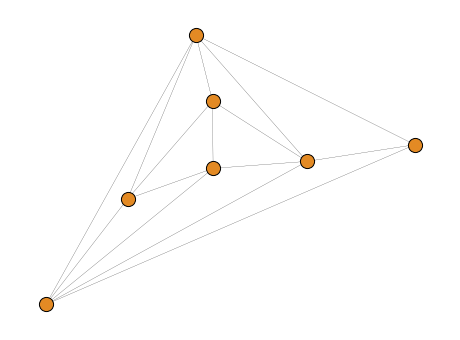

In [2]:
from utils import plot_graph, plot_farm_qty

plot_graph(data)

If you count the edges in this plot, you'll notice that there are only 15 compared to the 30 in the edge_index! This is because each edge is actually doubled when the graph is undirected (one edge in each direction).

 We can also overlay with some node features, for instance power and the inflow wind direction.

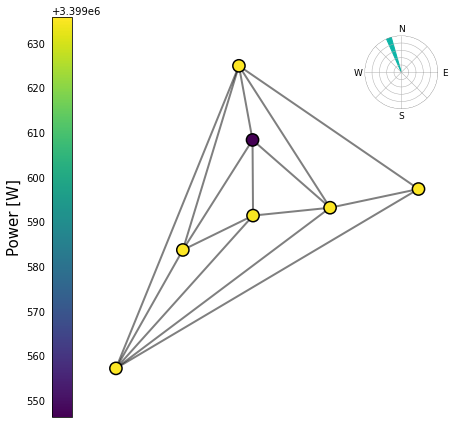

In [3]:
plot_farm_qty(data, var_idx_to_plot=0, show_graph=True, cmap_label='Power [W]')

### Setting up the GNN
Now that we have the graphs to train on, let's do some message-passing!

There are many different different kinds of message-passing, however all feature the following two main steps: 

1. For each edge compute the message based on the features of the two connected nodes (optionally also based on the edge features and the globals) 
$$\mathbf{m}_{i, j} = \phi (\mathbf{x}_{i}, \mathbf{x}_{j} , \mathbf{a}_{i, j}, \mathbf{w})$$

2. For each node, aggregate the incoming messages and update the node features using the aggregation, the previous node features and optionally the globals

$$\mathbf{x}_{i}'=\gamma (\mathbf{x} _{i}, \square _{j \in \mathcal{N}(i)}(\mathbf{m}_{i, j}), \mathbf{w})$$

- $\mathbf{x}$: node features of node $i$
- $\mathbf{a}_{j,i} \in R^E$: (optional) edge features from node $j$ to node $i$
- $\mathbf{w} \in R^W$: (optional) global features 
- $\square$: aggregation method (permutation invariant function). i.e., mean, sum, max
- $\gamma$, $\phi$: differentiable functions, such as MLP


# <div style="text-align:center"><img src="./assets/mp.png" style="width:40%;" /></div>


One of the most generic message-passing formulations is the 'Graph Net' introduced by [DeepMind](https://arxiv.org/abs/1806.01261). We're going to implement this one as it is quite easy to understand. The overall structure of one block of a GN is introduced below, essentially it is works by first updating the edge_attributes (this is equivalent to computing the messages), and then the node features using the aggregated messages and finally the globals (this is optional).

In [4]:
class GNBlock(torch.nn.Module):
    def __init__(self, node_in_dim, nodeMLP_dim_list, edge_in_dim, edgeMLP_dim_list, global_in_dim, globalMLP_dim_list):
        super().__init__()
        # first define the dimensions of the input to the node model and edge model
        nm_in_dim = node_in_dim + edge_in_dim + global_in_dim if global_in_dim is not None else node_in_dim + edge_in_dim
        em_in_dim = 2 * node_in_dim + edge_in_dim + global_in_dim if global_in_dim is not None else 2 * node_in_dim + edge_in_dim
        
        # then initialize 
        self.node_model = NodeModel(nm_in_dim, nodeMLP_dim_list, node_in_dim)
        self.edge_model = EdgeModel(em_in_dim, edgeMLP_dim_list, edge_in_dim)
        if global_in_dim is not None and globalMLP_dim_list is not None:
            gm_in_dim = node_in_dim + global_in_dim
            self.global_model = GlobModel(gm_in_dim, globalMLP_dim_list, global_in_dim)

    def forward(self, x, edge_index, edge_attr, w=None, batch=None):
        src = edge_index[0] # vector of indices of the sender/source nodes for each edge
        dest = edge_index[1] # vector of indices of the  receiver/destination nodes for each edge

        if self.edge_model is not None:
            edge_attr = self.edge_model(x[src], x[dest], edge_attr, w, batch if batch is None else batch[src])

        if self.node_model is not None:
            x = self.node_model(x, edge_index, edge_attr, w, batch)

        if self.global_model is not None:
            w = self.global_model(x, edge_index, edge_attr, w, batch)

        return x, edge_attr, w


You can notice in the forward pass the order described above. We'll now introduce each graph attribute updater model in that order. The EdgeModel is pretty straightforward, with simply an MLP which takes as input the sender and receiver node features, as well as the edge attributes and the globals. For single graph training this is pretty easy, it gets a bit more complicated with multi-graph (batch) training, where one needs to associate correctly each edge with the globals of the graph it belongs to. Notice that the bath dimension is simply all the edges, independently of which graph they belong to. This is quite different to how traditional deep learning works (with pixels for instance), but it is absolutely required to be able to train on graphs of variable sizes and connecitivities.

In [5]:
from torch_geometric.nn import MLP

class EdgeModel(torch.nn.Module):
    def __init__(self, edge_in_dim, edgeMLP_dim_list, edge_out_dim):
        super().__init__()
        channel_list = [edge_in_dim] + edgeMLP_dim_list + [edge_out_dim]
        self.edge_mlp  = MLP(channel_list=channel_list, activation_type='ReLU', norm_type='LayerNorm')

    def forward(self, src, dest, edge_attr, w, batch):
        # src, dest: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # w: [B, F_g], globals where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        if w is not None:
            out = torch.cat([src, dest, edge_attr, w[batch]], dim=1)
        else:
            out = torch.cat([src, dest, edge_attr], dim=1)
        out = self.edge_mlp(out) + edge_attr
        return out

Next we introduce the NodeModel. It is in this step that the aggregation happens. To do this efficiently, we use torch_scatter. The aggregated information is then fed into an MLP along with the old node features and the globals. 

Again notice how the batch dimension here is simply the number of nodes, even for multi-graph training! This is because unconnected nodes (from different graphs) cannot interact with each other. Only incoming messages (edge_attr) from connected edges can be used in the update. Care must taken when using the globals, similarly to the EdgeModel above.

In [6]:
from torch_scatter import scatter_sum

class NodeModel(torch.nn.Module):
    def __init__(self, node_in_dim, nodeMLP_dim_list, node_out_dim):
        super().__init__()
        channel_list = [node_in_dim] + nodeMLP_dim_list + [node_out_dim]
        self.node_mlp = MLP(channel_list=channel_list, activation_type='ReLU', norm_type='LayerNorm')

    def forward(self, x, edge_index, edge_attr, w, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # w: [B, F_g]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = scatter_sum(edge_attr, col, dim=0, dim_size=x.shape[0])
        if w is not None:
            out = torch.cat([x, out, w[batch]], dim=1)
        else:
            out = torch.cat([x, out], dim=1)
        out = self.node_mlp(out) + x
        return out

Finally, we can define the GlobalModel, which again uses a simple MLP to update the globals. The inputs to this MLP are the updated mean node features for each graph and the previous globals. We use torch_scatter to obtain the mean of the nodes for each graph efficiently.

In [7]:
from torch_scatter import scatter_mean

class GlobModel(torch.nn.Module):
    def __init__(self, global_in_dim, globalMLP_dim_list, global_out_dim):
        super().__init__()
        channel_list = [global_in_dim] + globalMLP_dim_list + [global_out_dim]
        self.global_mlp = MLP(channel_list=channel_list, activation_type='ReLU', norm_type='LayerNorm')

    def forward(self, x, edge_index, edge_attr, w, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # w: [B, F_g]
        # batch: [N] with max entry B - 1.
        out = torch.cat([w, scatter_mean(x, batch, dim=0)], dim=1)
        out = self.global_mlp(out) + w
        return out

Great, we have almost everything. We still need to define the typical encoding and decoding layers used for physics based GNNs. The idea here is that you want the message-passing to happen in a higher-dimensional latent space. In some sense this makes the GNN *wider*. We'll simply use shared-weight MLPs for this for all attributes of the graph, for both the encoder and decoder. We'll define these in the overall GNN model below.

In [8]:
class OurGNN(torch.nn.Module):
    def __init__(self, node_in_dim, node_out_dim, node_hidden_dim, edge_in_dim, edge_hidden_dim, global_in_dim, global_hidden_dim, num_mp_layers):
        super().__init__()
        
        # encoders are simply 1 hidden layer MLPs
        self.node_encoder = MLP(channel_list=[node_in_dim, node_hidden_dim, node_hidden_dim], activation_type='ReLU', norm_type='LayerNorm')
        self.edge_encoder = MLP(channel_list=[edge_in_dim, edge_hidden_dim, edge_hidden_dim], activation_type='ReLU', norm_type='LayerNorm')
        self.global_encoder = MLP(channel_list=[global_in_dim, global_hidden_dim, global_hidden_dim], activation_type='ReLU', norm_type='LayerNorm')
        
        # the GNBlock is the core of the GNN and will be applied num_mp_layers times
        self.mp_layers = torch.nn.ModuleList()
        for i in range(num_mp_layers):
            # each GNBlock will have the 2 hidden layer MLPs for all atributes
            self.mp_layers.append(GNBlock(node_hidden_dim, [node_hidden_dim, node_hidden_dim], edge_hidden_dim, [edge_hidden_dim, edge_hidden_dim], 
                                          global_hidden_dim, [global_hidden_dim, global_hidden_dim]))
        
        
        # node decoder is also 1 hidden layer MLPs
        self.node_decoder = MLP(channel_list=[node_hidden_dim, node_out_dim], activation_type='ReLU', norm_type=None)

    def forward(self, data):
        x, edge_index, edge_attr, w, batch = data.x, data.edge_index, data.edge_attr, data.globals, data.batch
        
        # encode the attributes
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        w = self.global_encoder(w)
        
        # do the message-passing
        for mp_layer in self.mp_layers:
            x, edge_attr, w = mp_layer(x, edge_index, edge_attr, w, batch)
            
        # decode the hidden node features back into output space
        x = self.node_decoder(x)
        
        return x

We now have our GNN model! Let's train it on the small example dataset. To make things easy, we provide an Dataset class to load in the data easily with a dataloader (which helps to make  multigraph training easy). This dataset class also adds an edge attribute (the relative angle of the edge to the wind direction)

In [9]:
from utils import GraphFarmsDataset
from torch_geometric.loader import DataLoader

model = OurGNN(node_in_dim=3, node_out_dim=5, node_hidden_dim=64, edge_in_dim=3, edge_hidden_dim=64, global_in_dim=3, global_hidden_dim=64, num_mp_layers=3)

dataset = GraphFarmsDataset(root_path='example_data/train')
loader = DataLoader(dataset, batch_size=10, shuffle=True)

# define the number of epochs
number_of_epochs = 100

# define the learning rate
lr = 5e-4

# define the loss function
loss_fn = torch.nn.MSELoss()

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=number_of_epochs)

# main training loop
for epoch in range(number_of_epochs):
    train_loss = 0
    model.train()

    # mini-batch loop
    for i_batch, data in enumerate(loader):
        # normalize all the features
        data.x, data.edge_attr, data.globals, data.y = dataset.normalize_sample(data.x, data.edge_attr, data.globals, data.y)
        
        # reset the gradients back to zero
        optimizer.zero_grad()

        # run forward pass and compute the batch training loss
        y_pred = model(data)
        batch_loss = loss_fn(y_pred, data.y)
        train_loss += batch_loss.item()

        # perform batched SGD parameter update
        batch_loss.backward()
        optimizer.step()
    
    scheduler.step()

    # compute the epoch training loss
    train_loss = train_loss / len(loader)

    # print the epoch training loss
    print(f'Epoch {epoch}, Loss: {train_loss}')

Epoch 0, Loss: 0.6194328534603118
Epoch 1, Loss: 0.5522441458702088
Epoch 2, Loss: 0.5562870115041733
Epoch 3, Loss: 0.4885278469324112
Epoch 4, Loss: 0.5392383790016174
Epoch 5, Loss: 0.4394917327165604
Epoch 6, Loss: 0.46916729390621187
Epoch 7, Loss: 0.45757934868335726
Epoch 8, Loss: 0.440491104722023
Epoch 9, Loss: 0.42873336672782897
Epoch 10, Loss: 0.41413250625133513
Epoch 11, Loss: 0.39507426202297213
Epoch 12, Loss: 0.45142926335334776
Epoch 13, Loss: 0.46409290850162505
Epoch 14, Loss: 0.4725922828912735
Epoch 15, Loss: 0.41551466166973117
Epoch 16, Loss: 0.43791576027870177
Epoch 17, Loss: 0.4086569368839264
Epoch 18, Loss: 0.42766750693321226
Epoch 19, Loss: 0.4305579334497452
Epoch 20, Loss: 0.44778834402561185
Epoch 21, Loss: 0.3979231679439545
Epoch 22, Loss: 0.4000159776210785
Epoch 23, Loss: 0.37850505650043487
Epoch 24, Loss: 0.40162565886974333
Epoch 25, Loss: 0.387099632024765
Epoch 26, Loss: 0.40626353859901426
Epoch 27, Loss: 0.4192471987009048
Epoch 28, Loss: 0.

We can take that trained model and predict on an unseen different (and much larger!)layout 

<Axes: >

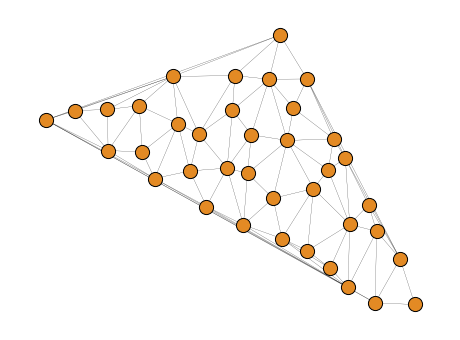

In [10]:
test_dataset = GraphFarmsDataset(root_path='example_data/test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
data = next(iter(test_loader))
plot_graph(data)

In [11]:
with torch.no_grad():
    model.eval()
    data = next(iter(test_loader))
    data.x, data.edge_attr, data.globals, data.y = dataset.normalize_sample(data.x, data.edge_attr, data.globals, data.y)
    y_pred = model(data)
y_pred, y = dataset.denormalize_sample(y_pred, data.y)

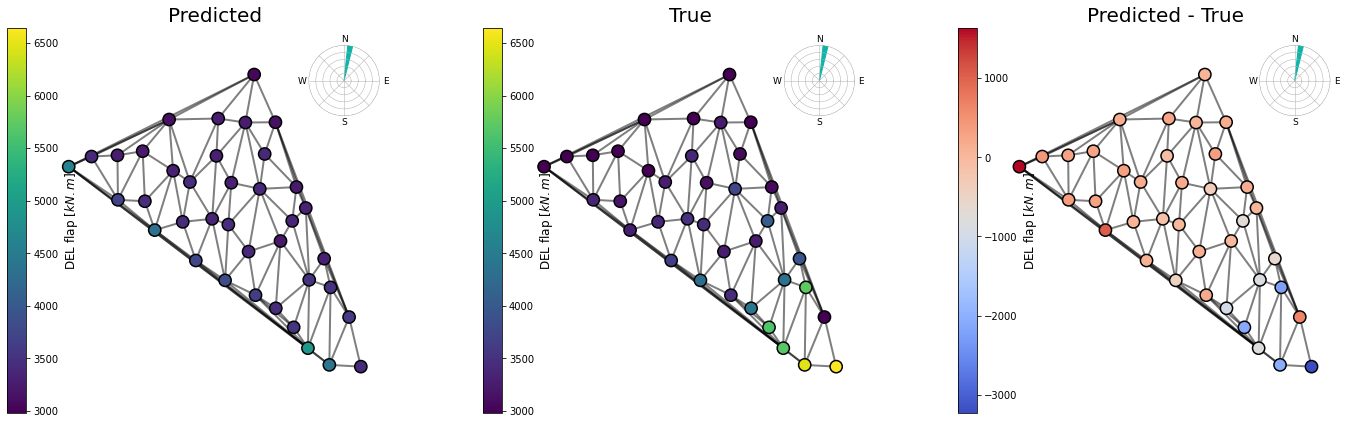

In [18]:
from utils import plot_farm_qty_diff
data = next(iter(test_loader))
plot_farm_qty_diff(data, y_pred, y, var_idx_to_plot=0, show_graph=True)


This is not great but it's also not too bad for a small model (only 3 MP layers with dim 64) trainedfor only 100 epochs on a tiny dataset of 250 conditions of the same small graph. Some wake-related patterns are starting to appear. You can also see how flexible this framework is, we can apply it to any wind farm layout!

#### Some final notes

In Pytorch Geometric, message-passing is not typically implemented as shown above. One would usually create a `nn.MessagePassing` object, in which the `self.propagate` method will do the message-passing by doing the following:
1. execute `self.message`, $\phi$: construct the message of **node pairs** `(x_i, x_j)`

2. execute `self.aggregate`, $\square$, aggregate message from neigbors. Internally, it uses [torch_scatter](https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/add.html) to do the aggregation efficiently.

3. execute `self.update`, $\gamma$:
    - update embedding of `Node i` with aggregated message , $i \in \mathcal{V}$   
    - e.g. aggregated neighbor message and self message


For instance, below is a simple example for the Graph Isomorphism Network (GIN), whose message-passing operation writes:
$$
\mathbf{x}^{\prime}_i = h_{\mathbf{\Theta}} \left( (1 + \epsilon) \cdot
        \mathbf{x}_i + \sum_{j \in \mathcal{N}(i)} \mathbf{x}_j \right)
$$

where $h_{\mathbf{\Theta}}$ is a MLP (here with 3 hidden layer of 10 neurons each) and $\epsilon$ is a hyperparameter

In [13]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import MLP

class GINLayer(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, eps: float = 0.):
        super(GINLayer, self).__init__(aggr='add') # here the "Add" aggregation is set (self.aggregate)
        self.nn = MLP(in_channels=in_channels, hidden_channels=10, out_channels=out_channels, num_layers=3)
        self.eps = eps

    def forward(self, x, edge_index):
        # x has shape [num_nodes, in_channels]
        # edge_index has shape [2, E]
        x_r = x # residual connection

        # start propagating messages (first messages are computed using self.message, then aggregated using self.aggregate)
        out = self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

        # apply the residual connection
        if x_r is not None:
            out = out + (1 + self.eps) * x_r
        
        # apply the output MLP h_theta
        return self.nn(out)

    def message(self, x_j):
        # here the message for each edge is simply the features of the neighbouring node j
        # x_j has shape [num_edges, out_channels]
        return x_j
    